### Install Libraries Needed

In [5]:
!pip install ipywidgets

### Import

In [ ]:

import os
import shutil
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D, LSTM, Bidirectional, Reshape, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0, ResNet50, Xception
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as res_preprocess
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# CONFIG
BASE_DIR = r"Dataset" 
FACE_PATH = "data_1/faces_1/"
AUDIO_PATH = "data_1/audio_specs_1/"
MODEL_DIR = "models_zoo_1/"

os.makedirs(FACE_PATH, exist_ok=True)
os.makedirs(AUDIO_PATH, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH_SIZE = 16

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow Version: 2.20.0
GPU Available: False


### Merge Dataset, EDA

In [25]:
def parse_datasets_auto(base_path):
    data = []
    print(f"Scanning {base_path} recursively...")
    
    rav_map = {
        "01": "neutral", "02": "neutral", "03": "happy", "04": "sad", 
        "05": "angry", "06": "fear", "07": "disgust", "08": "surprise"
    }
    crema_map = {
        "ANG": "angry", "DIS": "disgust", "FEA": "fear", 
        "HAP": "happy", "NEU": "neutral", "SAD": "sad"
    }

    for root, dirs, files in os.walk(base_path):
        for file in files:
            # RAVDESS
            if file.endswith('.mp4') and '-' in file:
                parts = file.split('.')[0].split('-')
                if len(parts) == 7:
                    emo_code = parts[2]
                    actor_id = parts[6]
                    if emo_code in rav_map:
                        data.append({
                            "path": os.path.join(root, file),
                            "source": "RAVDESS",
                            "label": rav_map[emo_code],
                            "actor": f"RAV_{actor_id}",
                            "original_id": f"RAV_{file}"
                        })
                        continue

            # CREMA-D
            if (file.endswith('.flv') or file.endswith('.mp4')) and '_' in file:
                parts = file.split('_')
                if len(parts) >= 3:
                    actor_id = parts[0]
                    emo_code = parts[2]
                    if emo_code in crema_map:
                        data.append({
                            "path": os.path.join(root, file),
                            "source": "CREMA-D",
                            "label": crema_map[emo_code],
                            "actor": f"CRE_{actor_id}",
                            "original_id": f"CRE_{file}"
                        })

    return pd.DataFrame(data)

full_df = parse_datasets_auto(BASE_DIR)

if len(full_df) == 0:
    print("WARNING: No files found! Check your BASE_DIR path.")
else:
    EMOTIONS = sorted(full_df['label'].unique())
    NUM_CLASSES = len(EMOTIONS)
    print(f"\nSuccess! Found {len(full_df)} files.")
    print(f"Emotions Found: {EMOTIONS}")

Scanning Dataset recursively...

Success! Found 9960 files.
Emotions Found: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


C:\Users\User\AppData\Local\Temp\ipykernel_18332\2443238697.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=full_df, x='label', order=EMOTIONS, palette='viridis')
C:\Users\User\AppData\Local\Temp\ipykernel_18332\2443238697.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=full_df, x='source', palette='magma')


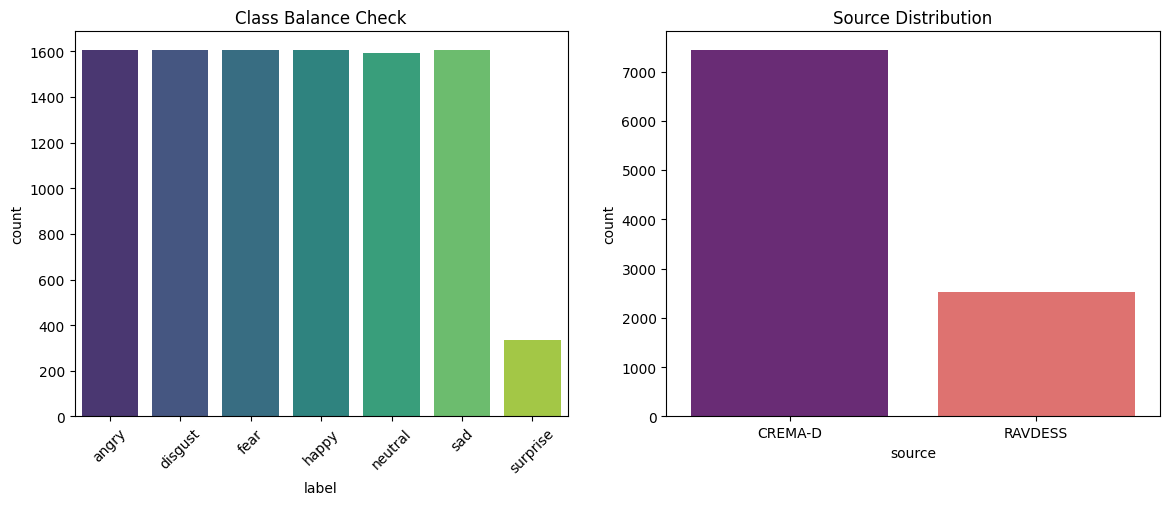


Computed Class Weights: {0: np.float64(0.8859633517167764), 1: np.float64(0.8859633517167764), 2: np.float64(0.8854120366254778), 3: np.float64(0.8854120366254778), 4: np.float64(0.8943162431534525), 5: np.float64(0.8854120366254778), 6: np.float64(4.23469387755102)}


In [29]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=full_df, x='label', order=EMOTIONS, palette='viridis')
plt.title("Class Balance Check"); plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
sns.countplot(data=full_df, x='source', palette='magma')
plt.title("Source Distribution"); plt.show()

y_ints = [EMOTIONS.index(x) for x in full_df['label']]
class_weights_arr = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_ints), y=y_ints
)
class_weights_dict = dict(enumerate(class_weights_arr))
print("\nComputed Class Weights:", class_weights_dict)

### Audio Extraction

In [ ]:
import librosa
from moviepy.editor import VideoFileClip
from tqdm.notebook import tqdm

def extract_audio_spectrogram(video_path, save_path):
    temp_wav = f"temp_{os.path.basename(save_path)}.wav"
    try:
        try:
            video = VideoFileClip(video_path)
            audio = video.audio
            if audio is None: return False
            audio.write_audiofile(temp_wav, fps=16000, logger=None)
            video.close()
        except Exception:
            return False

        y, sr = librosa.load(temp_wav, sr=16000)
        y_trimmed, _ = librosa.effects.trim(y, top_db=20)
        max_len = 16000 * 3
        
        if len(y_trimmed) > max_len:
            y_final = y_trimmed[:max_len]
        else:
            padding = max_len - len(y_trimmed)
            y_final = np.pad(y_trimmed, (0, padding), 'constant')
            
        mel = librosa.feature.melspectrogram(y=y_final, sr=sr, n_mels=128)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_norm = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-6)
        
        spec_img = np.stack([mel_norm]*3, axis=-1)
        spec_resized = cv2.resize(spec_img, (224, 224))
        np.save(save_path, spec_resized)
        return True
    except Exception as e:
        print(f"Error processing {video_path}: {e}")
        return False
    finally:
        if os.path.exists(temp_wav): os.remove(temp_wav)

audio_metadata = []
if not os.path.exists(AUDIO_PATH): os.makedirs(AUDIO_PATH)

print("Extracting Audio Features...")
for idx, row in tqdm(full_df.iterrows(), total=len(full_df)):
    fname = row['original_id'] + ".npy"
    save_p = os.path.join(AUDIO_PATH, fname)
    
    if os.path.exists(save_p):
        d = row.to_dict()
        d['audio_path'] = save_p
        audio_metadata.append(d)
        continue
        
    if extract_audio_spectrogram(row['path'], save_p):
        d = row.to_dict()
        d['audio_path'] = save_p
        audio_metadata.append(d)

audio_df = pd.DataFrame(audio_metadata)
print(f"Audio Extraction Complete. Valid samples: {len(audio_df)}")

Extracting Audio Features...


  0%|          | 0/9960 [00:00<?, ?it/s]

Audio Extraction Complete. Valid samples: 9960


### Face Extraction

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def process_faces(df):
    face_data = []
    print("Extracting Faces...")
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        cap = cv2.VideoCapture(row['path'])
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames <= 0:
            cap.release(); continue
            
        target_frame = int(total_frames / 2)
        cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame)
        ret, frame = cap.read()
        
        if ret:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.1, 5)
            
            if len(faces) > 0:
                x, y, w, h = sorted(faces, key=lambda f: f[2]*f[3], reverse=True)[0]
                margin = int(w * 0.2)
                x1 = max(0, x - margin); y1 = max(0, y - margin)
                x2 = min(frame.shape[1], x + w + margin); y2 = min(frame.shape[0], y + h + margin)
                face_img = frame[y1:y2, x1:x2]
                
                try:
                    face_img = cv2.resize(face_img, (224, 224))
                    fname = f"{row['original_id']}_face.jpg"
                    save_p = os.path.join(FACE_PATH, fname)
                    cv2.imwrite(save_p, face_img)
                    
                    d = row.to_dict()
                    d['face_path'] = save_p
                    face_data.append(d)
                except Exception: pass
        cap.release()
    return pd.DataFrame(face_data)

if not os.path.exists(FACE_PATH): os.makedirs(FACE_PATH)
face_df = process_faces(audio_df)
print(f"Face Extraction Complete. Valid samples: {len(face_df)}")

Extracting Faces...


  0%|          | 0/9960 [00:00<?, ?it/s]

Face Extraction Complete. Valid samples: 9949


### Save Dataset

In [ ]:
output_dir = r"C:\Users\User\Multimodel AI\data_1"
os.makedirs(output_dir, exist_ok=True)

if 'audio_df' in locals() and not audio_df.empty:
    audio_df.to_csv(os.path.join(output_dir, "audio_metadata.csv"), index=False)
if 'face_df' in locals() and not face_df.empty:
    face_df.to_csv(os.path.join(output_dir, "face_metadata.csv"), index=False)

### Generator & Encoding & Data Splitting

In [12]:
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(sorted(EMOTIONS)) 

class NpyDataGenerator(Sequence):
    def __init__(self, df, preprocess_func, batch_size=16, target_size=(224,224), shuffle=True, is_image=False):
        self.df = df
        self.batch_size = batch_size
        self.preprocess_func = preprocess_func
        self.target_size = target_size
        self.shuffle = shuffle
        self.is_image = is_image
        self.indices = np.arange(len(df))
        self.labels = le.transform(self.df[label_col])
        self.num_classes = len(le.classes_)
        self.on_epoch_end()

    def __len__(self): return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        idx_batch = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch, y_batch = [], []
        for i in idx_batch:
            row = self.df.iloc[i]
            path = row['face_path'] if self.is_image else row['audio_path']
            try:
                if self.is_image:
                    img = cv2.imread(path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, self.target_size)
                    data = img.astype(float)
                else:
                    data = np.load(path)
                    if data.shape[:2] != self.target_size:
                        data = cv2.resize(data, self.target_size)
            except:
                data = np.zeros(self.target_size + (3,))

            if data is not None:
                data = self.preprocess_func(data)
                X_batch.append(data)
                y_batch.append(self.labels[i])
        return np.array(X_batch), to_categorical(y_batch, num_classes=self.num_classes)

    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.indices)

In [ ]:
if face_df.empty:
    print("CRITICAL ERROR: Face DataFrame is empty.")
else:
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idxs, test_idxs = next(splitter.split(face_df, groups=face_df['actor']))
    train_df = face_df.iloc[train_idxs].reset_index(drop=True)
    test_val_df = face_df.iloc[test_idxs].reset_index(drop=True)

    splitter_val = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_idxs, test_final_idxs = next(splitter_val.split(test_val_df, groups=test_val_df['actor']))
    val_df = test_val_df.iloc[val_idxs].reset_index(drop=True)
    test_df = test_val_df.iloc[test_final_idxs].reset_index(drop=True)

    train_aud = audio_df[audio_df['original_id'].isin(train_df['original_id'])].reset_index(drop=True)
    val_aud = audio_df[audio_df['original_id'].isin(val_df['original_id'])].reset_index(drop=True)
    test_aud = audio_df[audio_df['original_id'].isin(test_df['original_id'])].reset_index(drop=True)
    print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 7962 | Val: 971 | Test: 1016


In [ ]:
output_dir = r"C:\Users\User\Multimodel AI\data_1"

os.makedirs(output_dir, exist_ok=True)
print(f"Saving files to: {output_dir}")

# Save Face Data
train_df.to_csv(os.path.join(output_dir, "train_face.csv"), index=False)
val_df.to_csv(os.path.join(output_dir, "val_face.csv"), index=False)
test_df.to_csv(os.path.join(output_dir, "test_face.csv"), index=False)

# Save Audio Data
train_aud.to_csv(os.path.join(output_dir, "train_audio.csv"), index=False)
val_aud.to_csv(os.path.join(output_dir, "val_audio.csv"), index=False)
test_aud.to_csv(os.path.join(output_dir, "test_audio.csv"), index=False)

print("Success! All 6 CSV files have been saved.")

Saving files to: C:\Users\User\Multimodel AI\data_1
Success! All 6 CSV files have been saved.


### Use this cell if crash

In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

data_dir = r"C:\Users\User\Multimodel AI\data_1"

try:
    train_df = pd.read_csv(os.path.join(data_dir, "train_face.csv"))
    val_df = pd.read_csv(os.path.join(data_dir, "val_face.csv"))
    test_df = pd.read_csv(os.path.join(data_dir, "test_face.csv"))
    
    train_aud = pd.read_csv(os.path.join(data_dir, "train_audio.csv"))
    val_aud = pd.read_csv(os.path.join(data_dir, "val_audio.csv"))
    test_aud = pd.read_csv(os.path.join(data_dir, "test_audio.csv"))
    
    print(f"Loaded CSVs from {data_dir}")

    dfs = [train_df, val_df, test_df, train_aud, val_aud, test_aud]
    
    for i, df in enumerate(dfs):
        if 'label_str' not in df.columns:
            if 'label' in df.columns:
                df['label_str'] = df['label'].astype(str)
            elif 'emotion' in df.columns:
                df['label_str'] = df['emotion'].astype(str)
            else:
                print(f"Warning: Could not find label column in DF {i}")
        
        df['label_str'] = df['label_str'].astype(str)
        if 'actor' in df.columns:
            df['actor'] = df['actor'].astype(str)

    print("Fixed 'label_str' columns.")

    le = LabelEncoder()
    le.fit(train_df['label_str'].unique())
    EMOTIONS = list(le.classes_)
    NUM_CLASSES = len(EMOTIONS)
    print(f"Recreated LabelEncoder. Classes: {EMOTIONS}")


    y_train_indices = le.transform(train_df['label_str'])
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_indices), y=y_train_indices)
    class_weights_dict = dict(enumerate(class_weights))
    print(f"Recreated Class Weights: {class_weights_dict}")

    print("\nSYSTEM RESTORED. You can now run the Fusion Training cell.")

except FileNotFoundError:
    print("Files not found. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")

Loaded CSVs from C:\Users\User\Multimodel AI\data_1
Fixed 'label_str' columns.
Recreated LabelEncoder. Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Recreated Class Weights: {0: np.float64(0.8893108455266391), 1: np.float64(0.8893108455266391), 2: np.float64(0.8886160714285715), 3: np.float64(0.8907036581273073), 4: np.float64(0.8886160714285715), 5: np.float64(0.8893108455266391), 6: np.float64(3.949404761904762)}

SYSTEM RESTORED. You can now run the Fusion Training cell.


### Audio Model Builder

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, LSTM, Bidirectional, Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0, ResNet50, Xception
from tensorflow.keras.regularizers import l2

tf.keras.backend.clear_session()
NUM_CLASSES = 7
AUDIO_IMG_SIZE = (224, 224)
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

def visualize_training(history, model, test_gen, name):
    print(f"\nVisualizing Performance for {name}...")
    
    # 1. Loss & Accuracy Curves
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(history.history['loss'], label='Train Loss', color='blue')
    ax[0].plot(history.history['val_loss'], label='Val Loss', color='orange')
    ax[0].set_title(f'{name} Loss'); ax[0].legend(); ax[0].grid(True)
    
    ax[1].plot(history.history['accuracy'], label='Train Acc', color='green')
    ax[1].plot(history.history['val_accuracy'], label='Val Acc', color='red')
    ax[1].set_title(f'{name} Accuracy'); ax[1].legend(); ax[1].grid(True)
    plt.tight_layout(); plt.show()

    # 2. Prediction Logic (Fixed for Generators without .reset)
    if hasattr(test_gen, 'reset'):
        test_gen.reset()
        
    preds = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(preds, axis=1)
    
    # Get True Labels safely
    if hasattr(test_gen, 'classes'):
        y_true = test_gen.classes
    else:
        y_true = []
        if hasattr(test_gen, 'reset'): 
            test_gen.reset()  
        for i in range(len(test_gen)):
            _, batch_y = test_gen[i]
            y_true.extend(np.argmax(batch_y, axis=1))
        y_true = np.array(y_true)
            
    # 3. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=EMOTIONS, yticklabels=EMOTIONS)
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('True Class'); plt.xlabel('Predicted Class'); plt.show()
    print(classification_report(y_true, y_pred, target_names=EMOTIONS))


In [ ]:
import gc
from tensorflow.keras.layers import Flatten
import time

### Face Model (EfficientNet)

Training Face_EfficientNet...
Found 7962 validated image filenames belonging to 7 classes.
Found 971 validated image filenames belonging to 7 classes.
Found 1016 validated image filenames belonging to 7 classes.
Epoch 1/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 1046s 2s/step - accuracy: 0.2931 - loss: 2.0972 - val_accuracy: 0.4706 - val_loss: 1.7487 - learning_rate: 1.0000e-04
Epoch 2/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 956s 2s/step - accuracy: 0.4800 - loss: 1.6684 - val_accuracy: 0.5705 - val_loss: 1.5174 - learning_rate: 1.0000e-04
Epoch 3/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 953s 2s/step - accuracy: 0.5835 - loss: 1.4233 - val_accuracy: 0.5922 - val_loss: 1.4870 - learning_rate: 1.0000e-04
Epoch 4/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 954s 2s/step - accuracy: 0.6285 - loss: 1.2938 - val_accuracy: 0.6179 - val_loss: 1.3924 - learning_rate: 1.0000e-04
Epoch 5/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 1123s 2s/step - accuracy: 0.6722 - loss: 1.1701 - val_accuracy: 0.6395 - val_loss: 1.3881 - learning_rate: 1.0000e-04
E

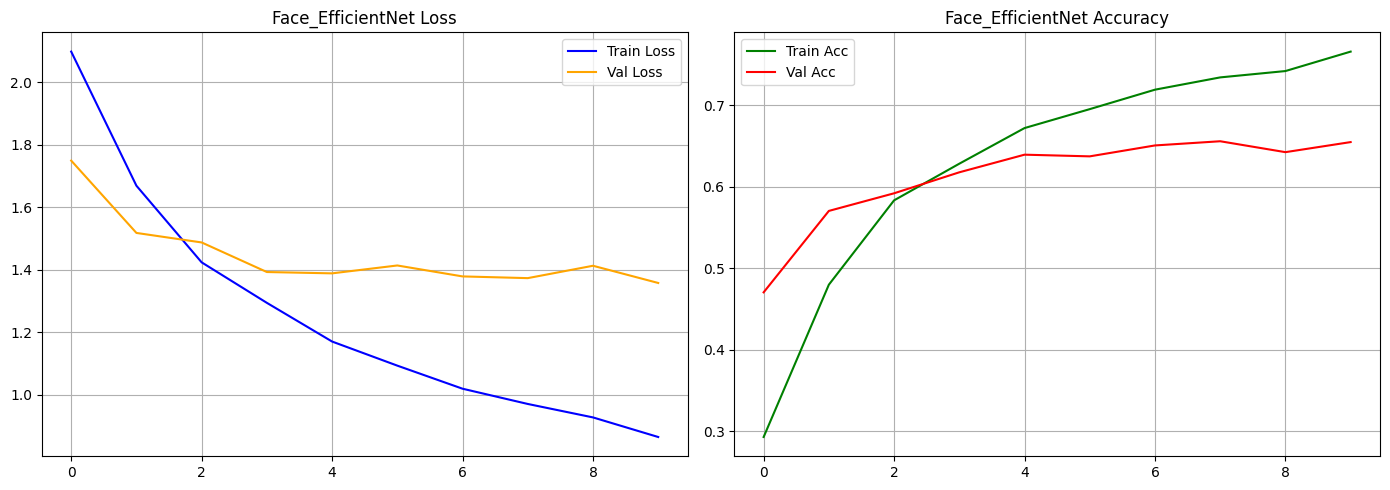

64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 414ms/step


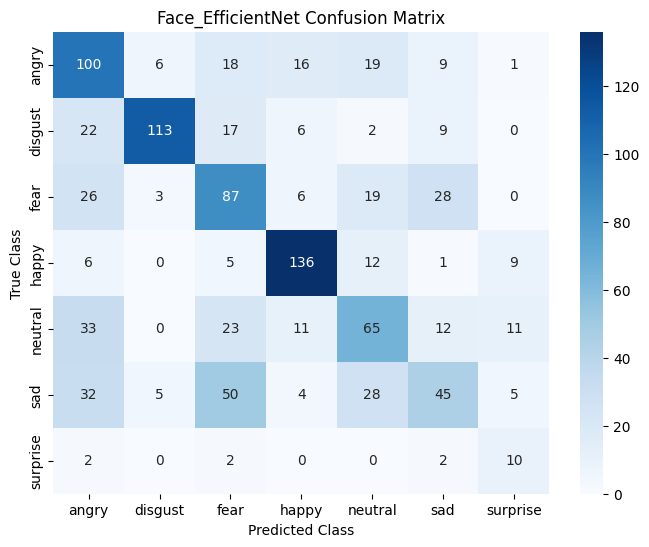

              precision    recall  f1-score   support

       angry       0.45      0.59      0.51       169
     disgust       0.89      0.67      0.76       169
        fear       0.43      0.51      0.47       169
       happy       0.76      0.80      0.78       169
     neutral       0.45      0.42      0.43       155
         sad       0.42      0.27      0.33       169
    surprise       0.28      0.62      0.38        16

    accuracy                           0.55      1016
   macro avg       0.53      0.56      0.52      1016
weighted avg       0.56      0.55      0.55      1016



In [ ]:
import tensorflow as tf
import time
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
import gc

tf.keras.backend.clear_session()
gc.collect()

NAME = "Face_EfficientNet"
print(f"Training {NAME}...")

label_column = 'label'
if 'label_str' in train_df.columns:
    label_column = 'label_str'

train_datagen = ImageDataGenerator(
    preprocessing_function=eff_preprocess,
    rotation_range=15,       # Reduced from 20
    width_shift_range=0.15,  # Reduced from 0.2
    height_shift_range=0.15, # Reduced from 0.2
    zoom_range=0.15,         # Reduced from 0.2
    horizontal_flip=True, 
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(preprocessing_function=eff_preprocess)

train_g = train_datagen.flow_from_dataframe(train_df, x_col='face_path', y_col=label_column, target_size=(224,224), batch_size=16, class_mode='categorical')
val_g = test_datagen.flow_from_dataframe(val_df, x_col='face_path', y_col=label_column, target_size=(224,224), batch_size=16, class_mode='categorical', shuffle=False)
test_g = test_datagen.flow_from_dataframe(test_df, x_col='face_path', y_col=label_column, target_size=(224,224), batch_size=16, class_mode='categorical', shuffle=False)

# + Regularization
def get_stabilized_face_model(base_model_class, input_shape, num_classes, name):
    base_model = base_model_class(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True # Fine-tuning
    
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x) # High dropout
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x) # L2 Reg
    x = layers.Dropout(0.4)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs, name=name)

model = get_stabilized_face_model(EfficientNetB0, (224,224,3), NUM_CLASSES, NAME)

# lower starting LR
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# (Added ReduceLROnPlateau)
callbacks = [
    # Reduce LR if val_loss stagnates for 2 epochs (Critical for stability)
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1),  
    # Early Stopping
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    # Save Best
    ModelCheckpoint(f"models_zoo_1/{NAME}.keras", save_best_only=True, monitor='val_accuracy')
]

# 5. Train
start_train = time.time()
hist = model.fit(
    train_g, 
    validation_data=val_g, 
    epochs=10, # Increased slightly to let LR scheduler work
    callbacks=callbacks, 
    class_weight=class_weights_dict, 
    verbose=1
)

end_train = time.time()
total_train_minutes = (end_train - start_train) / 60
print(f"Total Training Time: {total_train_minutes:.2f} minutes")

model.load_weights(f"models_zoo_1/{NAME}.keras")
visualize_training(hist, model, test_g, NAME)

Training efficientnet_improved...
Found 7962 validated image filenames belonging to 7 classes.
Found 971 validated image filenames belonging to 7 classes.
Found 1016 validated image filenames belonging to 7 classes.
Epoch 1/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 1003s 2s/step - accuracy: 0.1939 - loss: 2.6130 - val_accuracy: 0.2956 - val_loss: 2.1002 - learning_rate: 5.0000e-05
Epoch 2/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 1176s 2s/step - accuracy: 0.2764 - loss: 2.2990 - val_accuracy: 0.3934 - val_loss: 1.8664 - learning_rate: 5.0000e-05
Epoch 3/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 956s 2s/step - accuracy: 0.3287 - loss: 2.1184 - val_accuracy: 0.4387 - val_loss: 1.7285 - learning_rate: 5.0000e-05
Epoch 4/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 1083s 2s/step - accuracy: 0.3742 - loss: 1.9513 - val_accuracy: 0.4686 - val_loss: 1.6816 - learning_rate: 5.0000e-05
Epoch 5/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 1003s 2s/step - accuracy: 0.4005 - loss: 1.8685 - val_accuracy: 0.5304 - val_loss: 1.5801 - learning_rate: 5.0000

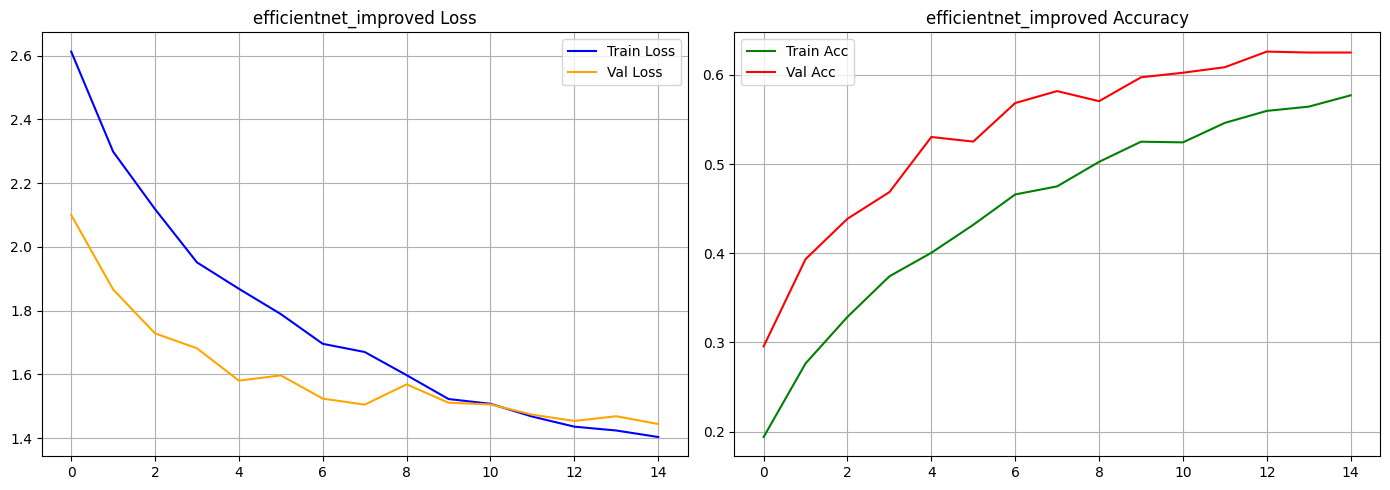

64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 499ms/step


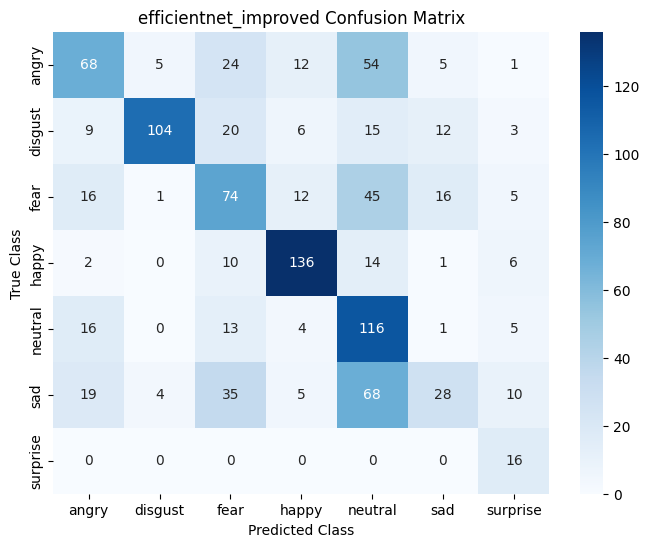

              precision    recall  f1-score   support

       angry       0.52      0.40      0.45       169
     disgust       0.91      0.62      0.73       169
        fear       0.42      0.44      0.43       169
       happy       0.78      0.80      0.79       169
     neutral       0.37      0.75      0.50       155
         sad       0.44      0.17      0.24       169
    surprise       0.35      1.00      0.52        16

    accuracy                           0.53      1016
   macro avg       0.54      0.60      0.52      1016
weighted avg       0.57      0.53      0.52      1016



In [ ]:
import tensorflow as tf
import time
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, regularizers, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import gc

tf.keras.backend.clear_session()
gc.collect()

NAME = "efficientnet_improved" 
print(f"Training {NAME}...")

train_datagen = ImageDataGenerator(
    preprocessing_function=eff_preprocess,
    rotation_range=25,        # Increased back to force learning shapes, not actors
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.2, 
    brightness_range=[0.8, 1.2], # Help model ignore actor-specific lighting
    horizontal_flip=True, 
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(preprocessing_function=eff_preprocess)

train_g = train_datagen.flow_from_dataframe(train_df, x_col='face_path', y_col=label_column, target_size=(224,224), batch_size=16, class_mode='categorical')
val_g = test_datagen.flow_from_dataframe(val_df, x_col='face_path', y_col=label_column, target_size=(224,224), batch_size=16, class_mode='categorical', shuffle=False)
test_g = test_datagen.flow_from_dataframe(test_df, x_col='face_path', y_col=label_column, target_size=(224,224), batch_size=16, class_mode='categorical', shuffle=False)

def get_improved_model(input_shape, num_classes):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True 
    
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs)
    
    # SpatialDropout2D is more effective for image generalization than standard Dropout
    x = layers.SpatialDropout2D(0.2)(x) 
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x) 
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

model = get_improved_model((224,224,3), NUM_CLASSES)

# 4. Use Label Smoothing (Crucial for closing the Val-Test gap)
model.compile(
    optimizer=optimizers.Adam(learning_rate=5e-5), # Lower LR for better stability
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 
    metrics=['accuracy']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    # Saves to the new filename
    ModelCheckpoint(f"models_zoo_1/{NAME}.keras", save_best_only=True, monitor='val_accuracy')
]

start_train = time.time()
hist = model.fit(
    train_g, 
    validation_data=val_g, 
    epochs=15, 
    callbacks=callbacks, 
    class_weight=class_weights_dict, 
    verbose=1
)

end_train = time.time()
print(f"Total Training Time: {(end_train - start_train) / 60:.2f} minutes")

model.load_weights(f"models_zoo_1/{NAME}.keras")
visualize_training(hist, model, test_g, NAME)

In [ ]:
import tensorflow as tf
import time
import gc
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras import layers, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess

# --- 1. SESSION CLEANUP & CONFIG ---
tf.keras.backend.clear_session()
gc.collect()

NAME = "efficientnet_improved_B2"
print(f"Training {NAME}...")

# B2 performs best at 260x260
TARGET_SIZE = (260, 260)
BATCH_SIZE = 16 # Reduce to 8 if you face Memory (OOM) errors

# Detect Label Column
label_column = 'label'
if 'label_str' in train_df.columns:
    label_column = 'label_str'

# --- 2. GENERATORS (High Augmentation for Actor Generalization) ---
train_datagen = ImageDataGenerator(
    preprocessing_function=eff_preprocess,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2], # Essential for differing CREMA-D/RADVESS lighting
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and Test should only use preprocessing
test_datagen = ImageDataGenerator(preprocessing_function=eff_preprocess)

train_g = train_datagen.flow_from_dataframe(
    train_df, x_col='face_path', y_col=label_column, 
    target_size=TARGET_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)
val_g = test_datagen.flow_from_dataframe(
    val_df, x_col='face_path', y_col=label_column, 
    target_size=TARGET_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)
test_g = test_datagen.flow_from_dataframe(
    test_df, x_col='face_path', y_col=label_column, 
    target_size=TARGET_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

# --- 3. MODEL ARCHITECTURE (B2 + Generalization Layers) ---
def get_final_b2_model(input_shape, num_classes):
    base_model = EfficientNetB2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True # Full fine-tuning
    
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs)
    
    # Spatial Dropout forces the model to use multiple facial features
    x = layers.SpatialDropout2D(0.3)(x) 
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x) 
    
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

model = get_final_b2_model((TARGET_SIZE[0], TARGET_SIZE[1], 3), NUM_CLASSES)

# --- 4. COMPILATION (Label Smoothing is the "Gap Killer") ---
model.compile(
    optimizer=optimizers.Adam(learning_rate=5e-5), # Lower LR for B2 stability
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 
    metrics=['accuracy']
)

# --- 5. CALLBACKS ---
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint(f"models_zoo_1/{NAME}.keras", save_best_only=True, monitor='val_accuracy')
]

# --- 6. TRAINING ---
start_train = time.time()
hist = model.fit(
    train_g, 
    validation_data=val_g, 
    epochs=20, # Increased epochs to allow slower LR to converge
    callbacks=callbacks, 
    class_weight=class_weights_dict, 
    verbose=1
)

end_train = time.time()
print(f"Total Training Time: {(end_train - start_train) / 60:.2f} minutes")

# --- 7. EVALUATION ---
model.load_weights(f"models_zoo_1/{NAME}.keras")
visualize_training(hist, model, test_g, NAME)

### Audio (EfficientNet)

In [5]:
label_column = 'label'
if 'label_str' in train_aud.columns:
    label_col = 'label_str'

In [8]:
import tensorflow as tf
import time
import gc
import numpy as np
import cv2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, regularizers, optimizers
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess

# --- 1. CLEANUP ---
tf.keras.backend.clear_session()
gc.collect()

NAME = "Audio_EfficientNet_Refined"
print(f"Training {NAME}...")

# --- 2. IMPROVED GENERATOR (Lighter Augmentation) ---
class NpyDataGenerator(Sequence):
    def __init__(self, df, preprocess_func, batch_size=16, target_size=(224,224), shuffle=True, is_image=False, augment=False):
        self.df = df
        self.batch_size = batch_size
        self.preprocess_func = preprocess_func
        self.target_size = target_size
        self.shuffle = shuffle
        self.is_image = is_image
        self.augment = augment
        self.indices = np.arange(len(df))
        self.labels = le.transform(self.df[label_col]) 
        self.num_classes = len(le.classes_)
        self.on_epoch_end()

    def __len__(self): 
        return int(np.ceil(len(self.df) / self.batch_size))

    def _augment_spectrogram(self, data):
        """
        Lightweight SpecAugment: Reduced mask sizes to prevent losing 
        critical emotion-bearing harmonics.
        """
        rows, cols, _ = data.shape
        
        # 1. Frequency Masking (Lighter: max 12 pixels)
        if np.random.random() < 0.4:
            f_len = np.random.randint(2, 12) 
            f0 = np.random.randint(0, rows - f_len)
            data[f0:f0+f_len, :, :] = 0 

        # 2. Time Masking (Lighter: max 12 pixels)
        if np.random.random() < 0.4:
            t_len = np.random.randint(2, 12)
            t0 = np.random.randint(0, cols - t_len)
            data[:, t0:t0+t_len, :] = 0

        return data

    def __getitem__(self, index):
        idx_batch = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch, y_batch = [], []
        
        for i in idx_batch:
            row = self.df.iloc[i]
            path = row['face_path'] if self.is_image else row['audio_path']
            
            try:
                data = np.load(path)
                if data.shape[:2] != self.target_size:
                    data = cv2.resize(data, self.target_size)
                
                # Ensure 3 channels for EfficientNet
                if len(data.shape) == 2:
                    data = np.stack([data]*3, axis=-1)
            except:
                data = np.zeros(self.target_size + (3,))

            if self.augment:
                data = self._augment_spectrogram(data)

            data = self.preprocess_func(data)
            X_batch.append(data)
            y_batch.append(self.labels[i])
                
        return np.array(X_batch), to_categorical(y_batch, num_classes=self.num_classes)

    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.indices)

# --- 3. MODEL & PREPROCESSING ---
def audio_preprocess_wrapper(img):  
    # Assuming .npy files are 0-1, scale to 0-255 for EfficientNet's internal scaling
    return eff_preprocess(img * 255.0)

train_gen = NpyDataGenerator(train_aud, audio_preprocess_wrapper, batch_size=16, augment=True)
val_gen = NpyDataGenerator(val_aud, audio_preprocess_wrapper, batch_size=16, shuffle=False, augment=False)
test_gen = NpyDataGenerator(test_aud, audio_preprocess_wrapper, batch_size=16, shuffle=False, augment=False)

def get_refined_audio_model(num_classes):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224,224,3))
    base_model.trainable = True # Fine-tuning
    
    inputs = layers.Input(shape=(224,224,3))
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x) # Higher dropout for noisy spectrograms
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

model = get_refined_audio_model(NUM_CLASSES)

# --- 4. COMPILATION & TRAINING ---
model.compile(
    optimizer=optimizers.Adam(learning_rate=5e-5), # Lower LR for stability
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), # Fixes prediction bias
    metrics=['accuracy']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint(f"models_zoo_1/{NAME}.keras", save_best_only=True, monitor='val_accuracy')
]

start_train = time.time()
hist = model.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=15, 
    callbacks=callbacks, 
    class_weight=class_weights_dict, 
    verbose=1
)

print(f"Total Training Time: {(time.time() - start_train) / 60:.2f} minutes")

# --- 5. EVALUATION ---
model.load_weights(f"models_zoo_1/{NAME}.keras")
visualize_training(hist, model, test_gen, NAME)

Training Audio_EfficientNet_Refined...
Epoch 1/15


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


498/498 ━━━━━━━━━━━━━━━━━━━━ 1043s 2s/step - accuracy: 0.2177 - loss: 2.6139 - val_accuracy: 0.2595 - val_loss: 2.1738 - learning_rate: 5.0000e-05
Epoch 2/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 923s 2s/step - accuracy: 0.2895 - loss: 2.2779 - val_accuracy: 0.3975 - val_loss: 1.7610 - learning_rate: 5.0000e-05
Epoch 3/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 1029s 2s/step - accuracy: 0.3090 - loss: 2.1701 - val_accuracy: 0.4356 - val_loss: 1.6875 - learning_rate: 5.0000e-05
Epoch 4/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 999s 2s/step - accuracy: 0.3488 - loss: 2.0171 - val_accuracy: 0.4634 - val_loss: 1.6460 - learning_rate: 5.0000e-05
Epoch 5/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 1038s 2s/step - accuracy: 0.3819 - loss: 1.9283 - val_accuracy: 0.4727 - val_loss: 1.5988 - learning_rate: 5.0000e-05
Epoch 6/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 1018s 2s/step - accuracy: 0.3981 - loss: 1.8389 - val_accuracy: 0.5067 - val_loss: 1.5632 - learning_rate: 5.0000e-05
Epoch 7/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 988s 2s/step - accuracy: 

NameError: name 'visualize_training' is not defined


Visualizing Performance for Audio_EfficientNet_Refined...


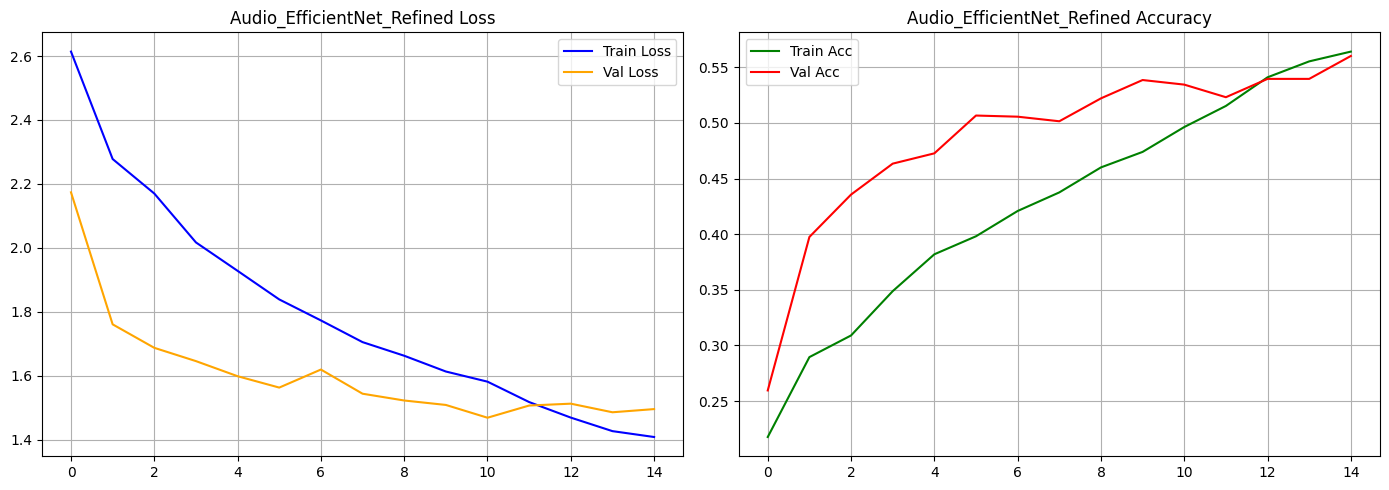

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 353ms/step


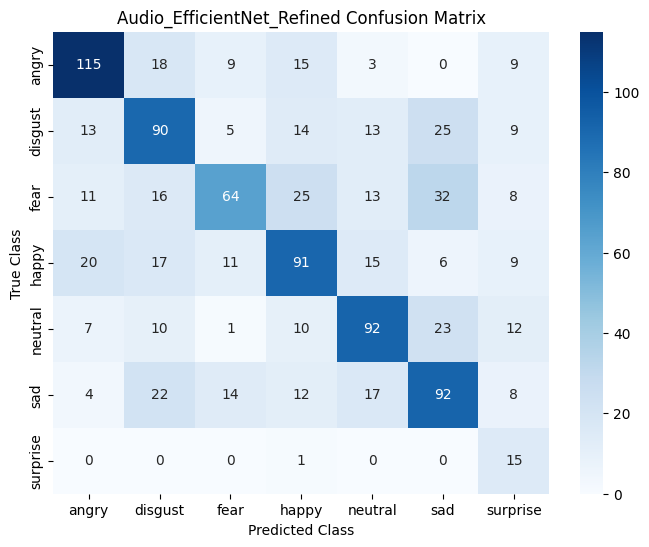

              precision    recall  f1-score   support

       angry       0.68      0.68      0.68       169
     disgust       0.52      0.53      0.53       169
        fear       0.62      0.38      0.47       169
       happy       0.54      0.54      0.54       169
     neutral       0.60      0.59      0.60       155
         sad       0.52      0.54      0.53       169
    surprise       0.21      0.94      0.35        16

    accuracy                           0.55      1016
   macro avg       0.53      0.60      0.53      1016
weighted avg       0.57      0.55      0.55      1016



In [10]:
visualize_training(hist, model, test_gen, NAME)